<a href="https://colab.research.google.com/github/alex-nuclearboy/goit-python-ds-project/blob/main/toxic_dataset_cleaning_alex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install transformers

In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Download the dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset
dataset_path = '/content/drive/My Drive/toxic_comments_data/train.csv'

# Load a dataset into a DataFrame
df_train = pd.read_csv(dataset_path)

Mounted at /content/drive


In [ ]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
# Check the number of labels for each class
column_labels = df_train.columns.tolist()[2:]
df_train[column_labels].sum().sort_values(ascending=False)

,0
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


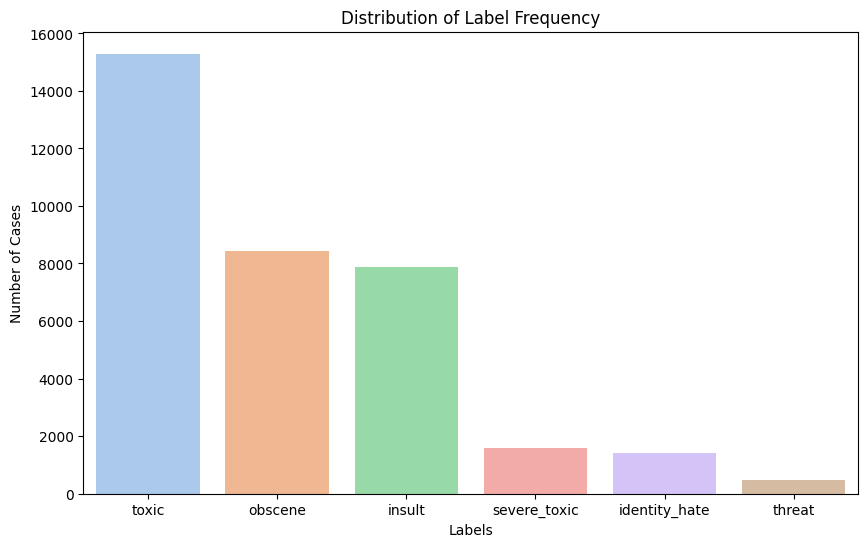

In [ ]:
# Visualizing the class distribution of the 'label' column
label_counts = df_train[column_labels].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))

ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='pastel', legend=False)

# Add labels and title to the plot
plt.xlabel('Labels')
plt.ylabel('Number of Cases')
plt.title('Distribution of Label Frequency')

plt.show()

Сheck if the data is balanced or not by comparing toxic and clean (non-toxic) comments by creating their subsets

In [ ]:
# Create subsets based on toxic and non-toxic comments
train_toxic = df_train[df_train[column_labels].sum(axis=1) > 0]
train_clean = df_train[df_train[column_labels].sum(axis=1) == 0]

# Number of toxic and non-toxic comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

print(f"Number of toxic comments: {num_toxic}")
print(f"Number of non-toxic comments: {num_clean}")

Number of toxic comments: 16225
Number of non-toxic comments: 143346


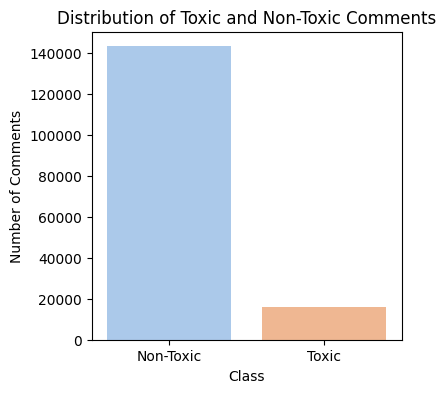

In [ ]:
# Create a DataFrame for visualization
plot_data = pd.DataFrame(
    {'Class': ['Non-Toxic', 'Toxic'], 'Count': [num_clean, num_toxic]})

plt.figure(figsize=(4, 4))

ax = sns.barplot(x='Class', y='Count', data=plot_data, hue='Class', palette='pastel', legend=False)


# Add labels and title to the plot
plt.xlabel('Class')
plt.ylabel('Number of Comments')
plt.title('Distribution of Toxic and Non-Toxic Comments')

plt.show()

Clean up the comment text by removing numbers, special characters, and excessive repetition

In [ ]:
import re

df_cleaned = df_train

def clean_text(text):

    # Convert text to lowercase
    text = text.lower()

    # Remove everything except English letters, commas, and periods
    text = re.sub(r"[^a-zA-Z.,\s]", "", text)

    # Remove all numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation marks except commas and periods
    text = re.sub(r'[^\w\s,.]', '', text)

    # Remove unnecessary punctuation marks except commas, periods, question marks, exclamation marks, and apostrophes
    text = re.sub(r'[^\w\s,.?!\']', '', text)

    # Remove excessive repetition of punctuation (limit to one occurrence)
    text = re.sub(r'([,.?!\'])\1+', r'\1', text)

    # Replace newlines with spaces
    text = text.replace('\n', ' ')

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove words longer than 40 characters
    text = re.sub(r'\S{40,}', '', text)

    # Regular expression to detect URLs and remove them
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)

    # Remove repeating words that occur more than twice in a row
    text = re.sub(r'(\b\w+\b)(\s+\1)+', r'\1', text)

    # Remove repeating sentences that occur more than twice in a row
    text = re.sub(r'(\b.+?\b)(\s*\1)+', r'\1', text)

    # Remove sequences of three or more identical letters (e.g., "aaaaa" -> "a")
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Remove repeating patterns of alternating characters
    text = re.sub(r'(.)(.)\1\2{2,}', r'\1\2', text)

    # Remove excessive laughter patterns (e.g., "ahahah" or "muahahah")
    text = re.sub(r'(ha|ah|mu|lol){2,}', '', text)

    # Remove phrases that repeat more than twice in a row
    text = re.sub(r'(\b\w+\b)(\s+\1){2,}', r'\1', text)

    # Remove sequences of repeated phrases (allowing only the first occurrence)
    text = re.sub(r'\b(\w+\b(?:\s+\w+\b){0,5})\s*(\1\s*)+', r'\1', text)

    # Remove long repetitions of the same word (more than 2 times)
    text = re.sub(r'\b(\w+)\s+\1\s+\1(?:\s+\1)+', r'\1', text)

    # Reduce long sequences of laughter (e.g., "ahahaha", "lol") to 1-2 occurrences
    text = re.sub(r'(\b(?:ha|ah|lol|mu|muah)+\b(?:\s*\b(?:ha|ah|lol|mu|muah)+\b){2,})', r'\1', text)

    return text


In [ ]:
# Apply the clean_text function to each comment
df_cleaned['comment_text'] = df_cleaned['comment_text'].apply(clean_text)

In [ ]:
df_cleaned.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, im really not trying to edit war. its...",0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make any real suggestions on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to count the number of tokens in a comment
def count_tokens(comment):
    tokens = tokenizer.tokenize(comment)  # Tokenize the comment
    return len(tokens)

# Add a new column with the token count
df_cleaned['token_count'] = df_cleaned['comment_text'].apply(count_tokens)

# Check the results
df_cleaned[['comment_text', 'token_count']].head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,comment_text,token_count
0,explanation why the edits made under my userna...,54
1,daww he matches this background colour im seem...,20
2,"hey man, im really not trying to edit war. its...",48
3,more i cant make any real suggestions on impro...,119
4,"you, sir, are my hero. any chance you remember...",17


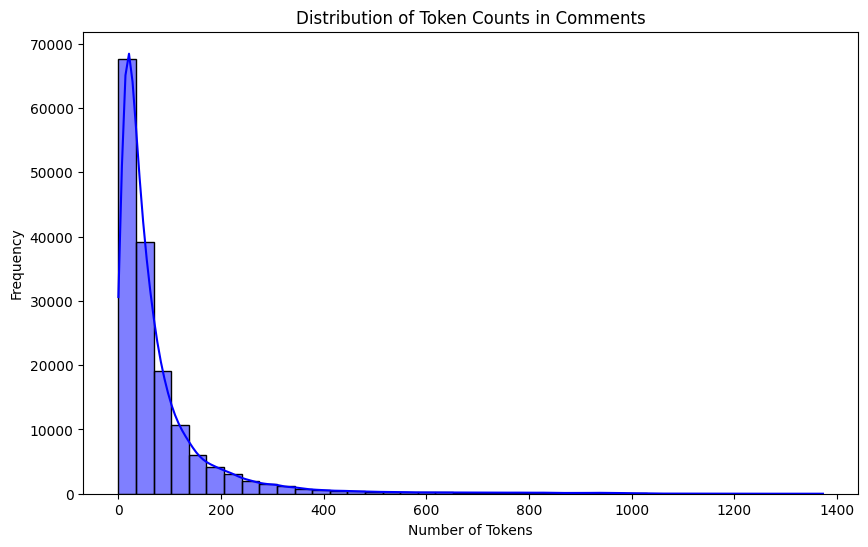

In [ ]:
# Create a histogram of the token counts
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['token_count'], bins=40, kde=True, color='blue')

plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts in Comments')

plt.show()

In [ ]:
# Sort the DataFrame by token count in descending order and get the top 20 comments
top_20_comments = df_cleaned.sort_values(by='token_count', ascending=False).head(20)

# Display the comments and their token counts
print(top_20_comments[['comment_text', 'token_count']])

                                             comment_text  token_count
80819   references i dont like deleting other peoples ...         1373
147587  neautrality and balance. article is strong ant...         1361
48976   english translation of page tab kose mihalin t...         1279
115467  vice admiral arbuthnot failed with his fquadro...         1226
18698   added. you arenwo on my yahoo list. lets be ci...         1206
108277  , admits that, if less unjust and violent meas...         1201
18100   you swine. you vulgar little maggot. you worth...         1197
31585   chokhor rinpoche a brief biography of fourth c...         1139
31594   moving ahead i just found that i am unblocked ...         1127
141961  sincere reply to ninlil dear ninhil, i thank y...         1125
77841   deliver me, o lord, from the evil man rescue m...         1122
134370  thiru muruga kirupanandha variyar, popularly k...         1121
90741   reply in good faith to ninlil from srirangam d...         1119
82334 

The BERT model can process texts of the maximal length of **512 tokens**, so let's check how many comments are longer

In [ ]:
# Count the number of comments with more than 512 tokens
count_above_limit = df_cleaned[df_cleaned['token_count'] > 512].shape[0]

# Calculate the percentage
percentage_above_limit = (count_above_limit / df_cleaned.shape[0]) * 100

print(
    "Number of comments with more than 512 tokens: "
    f"{count_above_limit} out of {df_cleaned.shape[0]} ({percentage_above_limit:.2f}%)"
    )

Number of comments with more than 512 tokens: 2510 out of 159571 (1.57%)


In [ ]:
# Save the cleaned DataFrame to a CSV file on Google Drive
output_file_path = '/content/drive/MyDrive/toxic_comments_data/train_data_cleaned.csv'
df_cleaned.to_csv(output_file_path, index=False)

print(f"Cleaned dataset saved to: {output_file_path}")

Cleaned dataset saved to: /content/drive/MyDrive/toxic_comments_data/train_data_cleaned.csv


### Token Count-Based Comment Processing

For comments exceeding 512 tokens, a summarization function is applied. It tokenizes text, calculates word frequencies (excluding stop words), and scores sentences based on these frequencies.

In [ ]:
from transformers import BigBirdTokenizer, BigBirdForMaskedLM

# Load the BigBird model and tokeniser
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
model = BigBirdForMaskedLM.from_pretrained('google/bigbird-roberta-base')

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

In [ ]:
# Function for shortening the text of comments
def summarize_comments(text, max_tokens=512):
    # Text tokenisation
    inputs = tokenizer(text, return_tensors="pt", max_length=4096, truncation=True)

    # Generate shortened text
    with torch.no_grad():  # Disable the calculation of gradients
        summary_ids = model.generate(inputs['input_ids'], max_length=max_tokens + inputs['input_ids'].shape[1])

    # Decoding the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [ ]:
# Create a new column 'summarized_comment'
summarized_comments = []

# Iterate through each row in the DataFrame
for idx, row in df_cleaned.iterrows():
    # Get the comment text and token count for the current row
    comment_text = row['comment_text']
    token_count = row['token_count']

    # If the token count is greater than 512, summarize the comment
    if token_count > 512:
        summarized_comment = summarize_comments(comment_text)
    else:
        # If the token count is 512 or less, keep the original comment
        summarized_comment = comment_text

    # Append the summarized or original comment to the list
    summarized_comments.append(summarized_comment)

# Update the DataFrame with the new column of summarized comments
df_cleaned['summarized_comment'] = summarized_comments

In [ ]:
# Display the DataFrame with summarized comments
df_cleaned[['comment_text', 'summarized_comment', 'token_count']].head()

,comment_text,summarized_comment,token_count
0,explanation why the edits made under my userna...,explanation why the edits made under my userna...,54
1,daww he matches this background colour im seem...,daww he matches this background colour im seem...,20
2,"hey man, im really not trying to edit war. its...","hey man, im really not trying to edit war. its...",48
3,more i cant make any real suggestions on impro...,more i cant make any real suggestions on impro...,119
4,"you, sir, are my hero. any chance you remember...","you, sir, are my hero. any chance you remember...",17


In [ ]:
# Save the updated DataFrame to a CSV file on Google Drive
output_summarized_file_path = '/content/drive/MyDrive/toxic_comments_data/train_data_summarized.csv'
df_cleaned.to_csv(output_summarized_file_path, index=False)

print(f"Updated dataset with summarized comments saved to: {output_summarized_file_path}")

Updated dataset with summarized comments saved to: /content/drive/MyDrive/toxic_comments_data/train_data_summarized.csv


In [ ]:
# Add a new column with the token count
df_cleaned['token_count_sum'] = df_cleaned['summarized_comment'].apply(count_tokens)

# Sort the DataFrame by token count in descending order and get the top 20 comments
top_20_comments = df_cleaned.sort_values(by='token_count_sum', ascending=False).head(20)

# Display the comments and their token counts
top_20_comments[['comment_text', 'summarized_comment', 'token_count', 'token_count_sum']]

<ipython-input-31-64a3fa23c49c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['token_count_sum'] = df_cleaned['summarized_comment'].apply(count_tokens)


,comment_text,summarized_comment,token_count,token_count_sum
147587,neautrality and balance. article is strong ant...,nop use salute which has been used in poland b...,1361,986
80819,references i dont like deleting other peoples ...,"melloleito, c. f. de. bcherl, w., a timotheo d...",1373,977
138179,exactly. alot of this information you cannot f...,like if you want the list i can put it here ch...,924,897
70256,"negotiation for unblock , i have a treat for y...",ltd g wikipedia talkarticles for creationitvs ...,832,832
48976,english translation of page tab kose mihalin t...,history teacher researcher and chronic in otto...,1279,829
158966,i list the peer reviewed publications that sup...,"timiras, h. sternberg, m. voelker experimental...",927,811
115006,i am really upset with his deletion nomination...,"tw , march diff hist . n user talkjarmanpreet ...",924,805
137112,apata sahi is a village under prataparudra pur...,apata sahi is located km distance from its dis...,1012,800
108277,", admits that, if less unjust and violent meas...","eliphas lvi, histoire de la magie, p. . dixit ...",1201,794
63164,"you are asshole master of deletions , march di...","tw , march diff hist . n user talkjarmanpreet ...",895,776
